Problem description

We are given three columns of integers with a row for each node. The first two columns contain x
and y coordinates of the node positions in a plane. The third column contains node costs. 

The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to
be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the
sum of the total length of the path plus the total cost of the selected nodes is minimized.
The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

Greedy heuristics

Implement three methods:

- Random solution
- Nearest neighbor
- Greedy cycle

adapted to our problem.

For each greedy method generate 200 solutions starting from each node. Generate also 200 random
solutions.

The report should contain:

- Description of the problem
- Pseudocode of all implemented algorithms
- Results of a computational experiment: for each instance and method min, max and average
value of the objective function.
- 2D visualization of the best solution for each instance and methods. Cost of nodes should be
presented e.g. by a color, greyscale, or size.
- (link to) source code
- Conclusions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_euclidean_distance(node1, node2):
    return np.round(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))

In [3]:
def get_distance_matrix(df):
    num_nodes = df.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        node1 = df.iloc[i]
        for j in range(i, num_nodes):
            node2 = df.iloc[j]
            distance = calculate_euclidean_distance(node1, node2)
            distance_matrix[i,j] = distance + node2['cost']
            distance_matrix[j,i] = distance + node1['cost']
    return distance_matrix

## Random search

In [4]:
def random_search(distance_matrix, current_node_index=None):
    to_visit = set(range(len(distance_matrix)))
    
    if current_node_index is None:
        current_node_index = np.random.choice(list(to_visit))
    
    current_node = current_node_index
    solution = [current_node]
    total_cost = distance_matrix[current_node, current_node]
    to_visit.remove(current_node_index)
    
    while to_visit:
        next_node_index = np.random.choice(list(to_visit))
        next_node = next_node_index
        total_cost += distance_matrix[current_node, next_node]
        solution.append(next_node)
        to_visit.remove(next_node_index)
        current_node = next_node
    
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-1], solution[0]]
    
    return solution, total_cost


## Nearest neighbor

In [5]:
def nearest_neighbor(distance_matrix, current_node_index=None):
    to_visit = set(range(len(distance_matrix)))
    
    if current_node_index is None:
        current_node_index = np.random.choice(list(to_visit))
    
    current_node = current_node_index
    solution = [current_node]
    total_cost = 0
    to_visit.remove(current_node_index)
    
    while to_visit:
        closest_neighbor = min(to_visit, key=lambda neighbor: distance_matrix[current_node, neighbor])
        closest_neighbor_distance = distance_matrix[current_node, closest_neighbor]
        
        total_cost += closest_neighbor_distance
        solution.append(closest_neighbor)
        to_visit.remove(closest_neighbor)
        current_node = closest_neighbor
    
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-2], solution[0]]
    
    return solution, total_cost


## Greedy cycle

In [6]:
def greedy_cycle(distance_matrix, current_node_index=None):
    to_visit = set(range(len(distance_matrix)))
    
    if current_node_index is None:
        current_node_index = np.random.choice(list(to_visit))
    
    current_node = current_node_index
    solution = [current_node]
    total_cost = 0
    
    to_visit.remove(current_node_index)
    
    while to_visit:
        closest_neighbor = None
        closest_neighbor_distance = float("inf")
        closest_neighbor_position = None
        
        for neighbor in to_visit:
            if len(solution) == 1:
                neighbor_distance = distance_matrix[current_node, neighbor] + distance_matrix[neighbor, current_node]
                candidate_position = 1
            else:
                distances = [
                    distance_matrix[solution[i-1], neighbor] + distance_matrix[neighbor, solution[i]] - distance_matrix[solution[i-1], solution[i]] 
                    for i in range(1, len(solution))
                ]
                neighbor_distance, candidate_position = min((dist, pos) for pos, dist in enumerate(distances, start=1))
            
            if neighbor_distance < closest_neighbor_distance:
                closest_neighbor = neighbor
                closest_neighbor_distance = neighbor_distance
                closest_neighbor_position = candidate_position
        
        total_cost += closest_neighbor_distance
        solution.insert(closest_neighbor_position, closest_neighbor)
        to_visit.remove(closest_neighbor)
    
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-2], solution[0]]
    
    return solution, total_cost


In [7]:
def run_experiment(file_name, algorithm, consider_current_index=False):
    
    path = "../data"
    num_repetitions = 200
    solutions = list()
    total_costs = list()
    datas = list()
    
    for repetition in range(num_repetitions):
        data = pd.read_csv(f"{path}/{file_name}.csv", sep=';', header=None, names=['x', 'y', 'cost'])
        top_row = data.iloc[repetition]
        remaining_sample = data.drop(repetition).sample(frac=0.5, replace=False, random_state=repetition)
        selected_nodes = pd.concat([top_row.to_frame().transpose(), remaining_sample])
#         selected_nodes = data.sample(frac=0.5)
        distance_matrix = get_distance_matrix(selected_nodes)
        datas.append(selected_nodes)

        if consider_current_index:
            results = algorithm(distance_matrix, 0)
        else:
            results = algorithm(distance_matrix)
        
        solutions.append(results[0])
        total_costs.append(results[1])
    
    min_cost = min(total_costs)
    max_cost = max(total_costs)
    avg_cost = sum(total_costs) / len(total_costs)
    best_solution = solutions[np.argmin(total_costs)]
    data = datas[np.argmin(total_costs)]
    
    return min_cost, max_cost, avg_cost, best_solution, data

In [8]:
def get_results(file_name):

    best_solutions = dict()
    datas = dict()
    results_df = pd.DataFrame(columns=['algorithm', 'min', 'avg', 'max'])
    for algo in (random_search, nearest_neighbor, greedy_cycle):
        if algo is random_search:
            min_cost, max_cost, avg_cost, best_solution, data = run_experiment(file_name, algo)
#             min_cost -= sum(selected_nodes['cost'])
        else:
            min_cost, max_cost, avg_cost, best_solution, data = run_experiment(file_name, algo, True)
#             min_cost -= sum(selected_nodes['cost'])
        results_df = results_df.append({'algorithm': algo.__name__, 'min': min_cost, 'avg': avg_cost, 'max': max_cost}, ignore_index=True)
        best_solutions[algo.__name__] = best_solution
        datas[algo.__name__] = data
    return best_solutions, results_df, datas

In [9]:
instances = ['A', 'B', 'C', 'D']
dataframes = dict()
all_best_solutions = dict()
datas = dict()
for instance in instances:
    file = f'TSP{instance}'
    best_solutions, results_df, data = get_results(file)
    dataframes[file] = results_df
    all_best_solutions[file] = best_solutions
    datas[file] = data

In [10]:
for instance, frame in dataframes.items():
    print(instance)
    display(frame)
    print('\n')

TSPA


algorithm       min        avg       max
0     random_search  238655.0  267313.81  294310.0
1  nearest_neighbor  135141.0  147430.97  158782.0
2      greedy_cycle  118584.0  127254.43  138826.0



TSPB


algorithm       min         avg       max
0     random_search  245324.0  268884.015  291325.0
1  nearest_neighbor  126538.0  145450.965  157271.0
2      greedy_cycle  109167.0  123919.615  136597.0



TSPC


algorithm       min         avg       max
0     random_search  194147.0  216095.200  245638.0
1  nearest_neighbor   83573.0   89807.765   96561.0
2      greedy_cycle   71141.0   76829.745   82435.0



TSPD


algorithm       min         avg       max
0     random_search  193020.0  219036.745  246188.0
1  nearest_neighbor   78130.0   89119.370   96804.0
2      greedy_cycle   66803.0   75358.310   82479.0

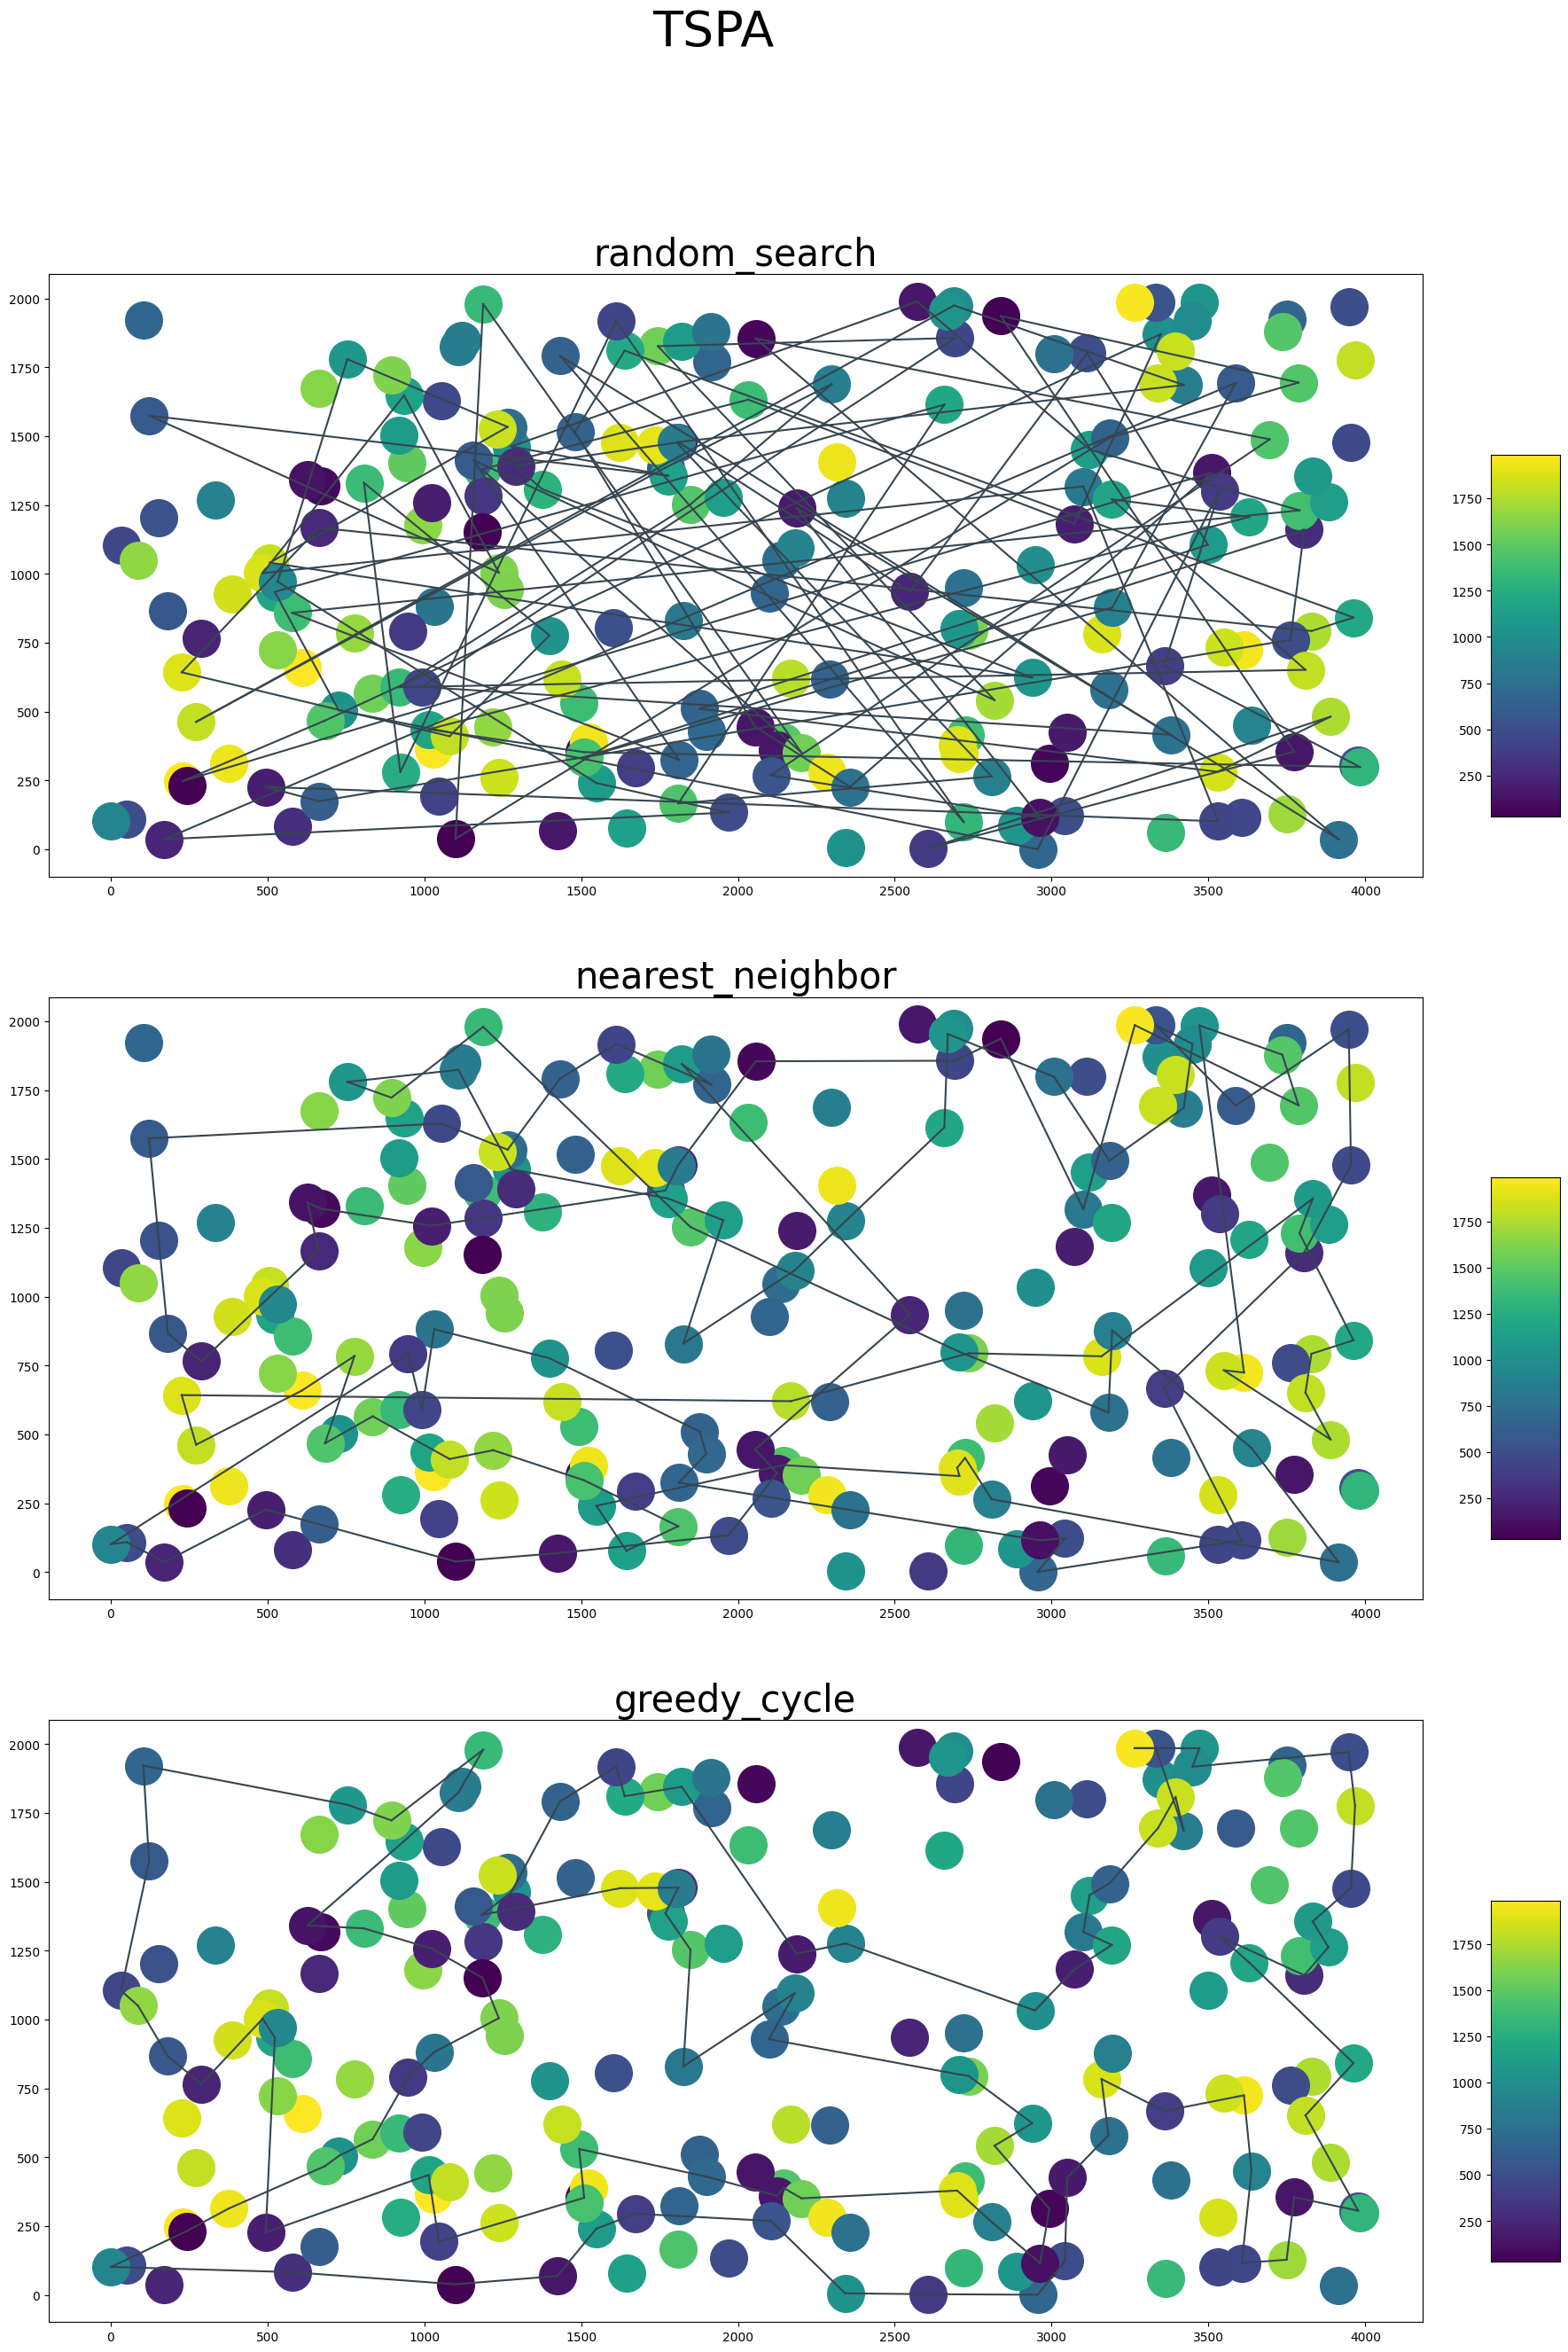

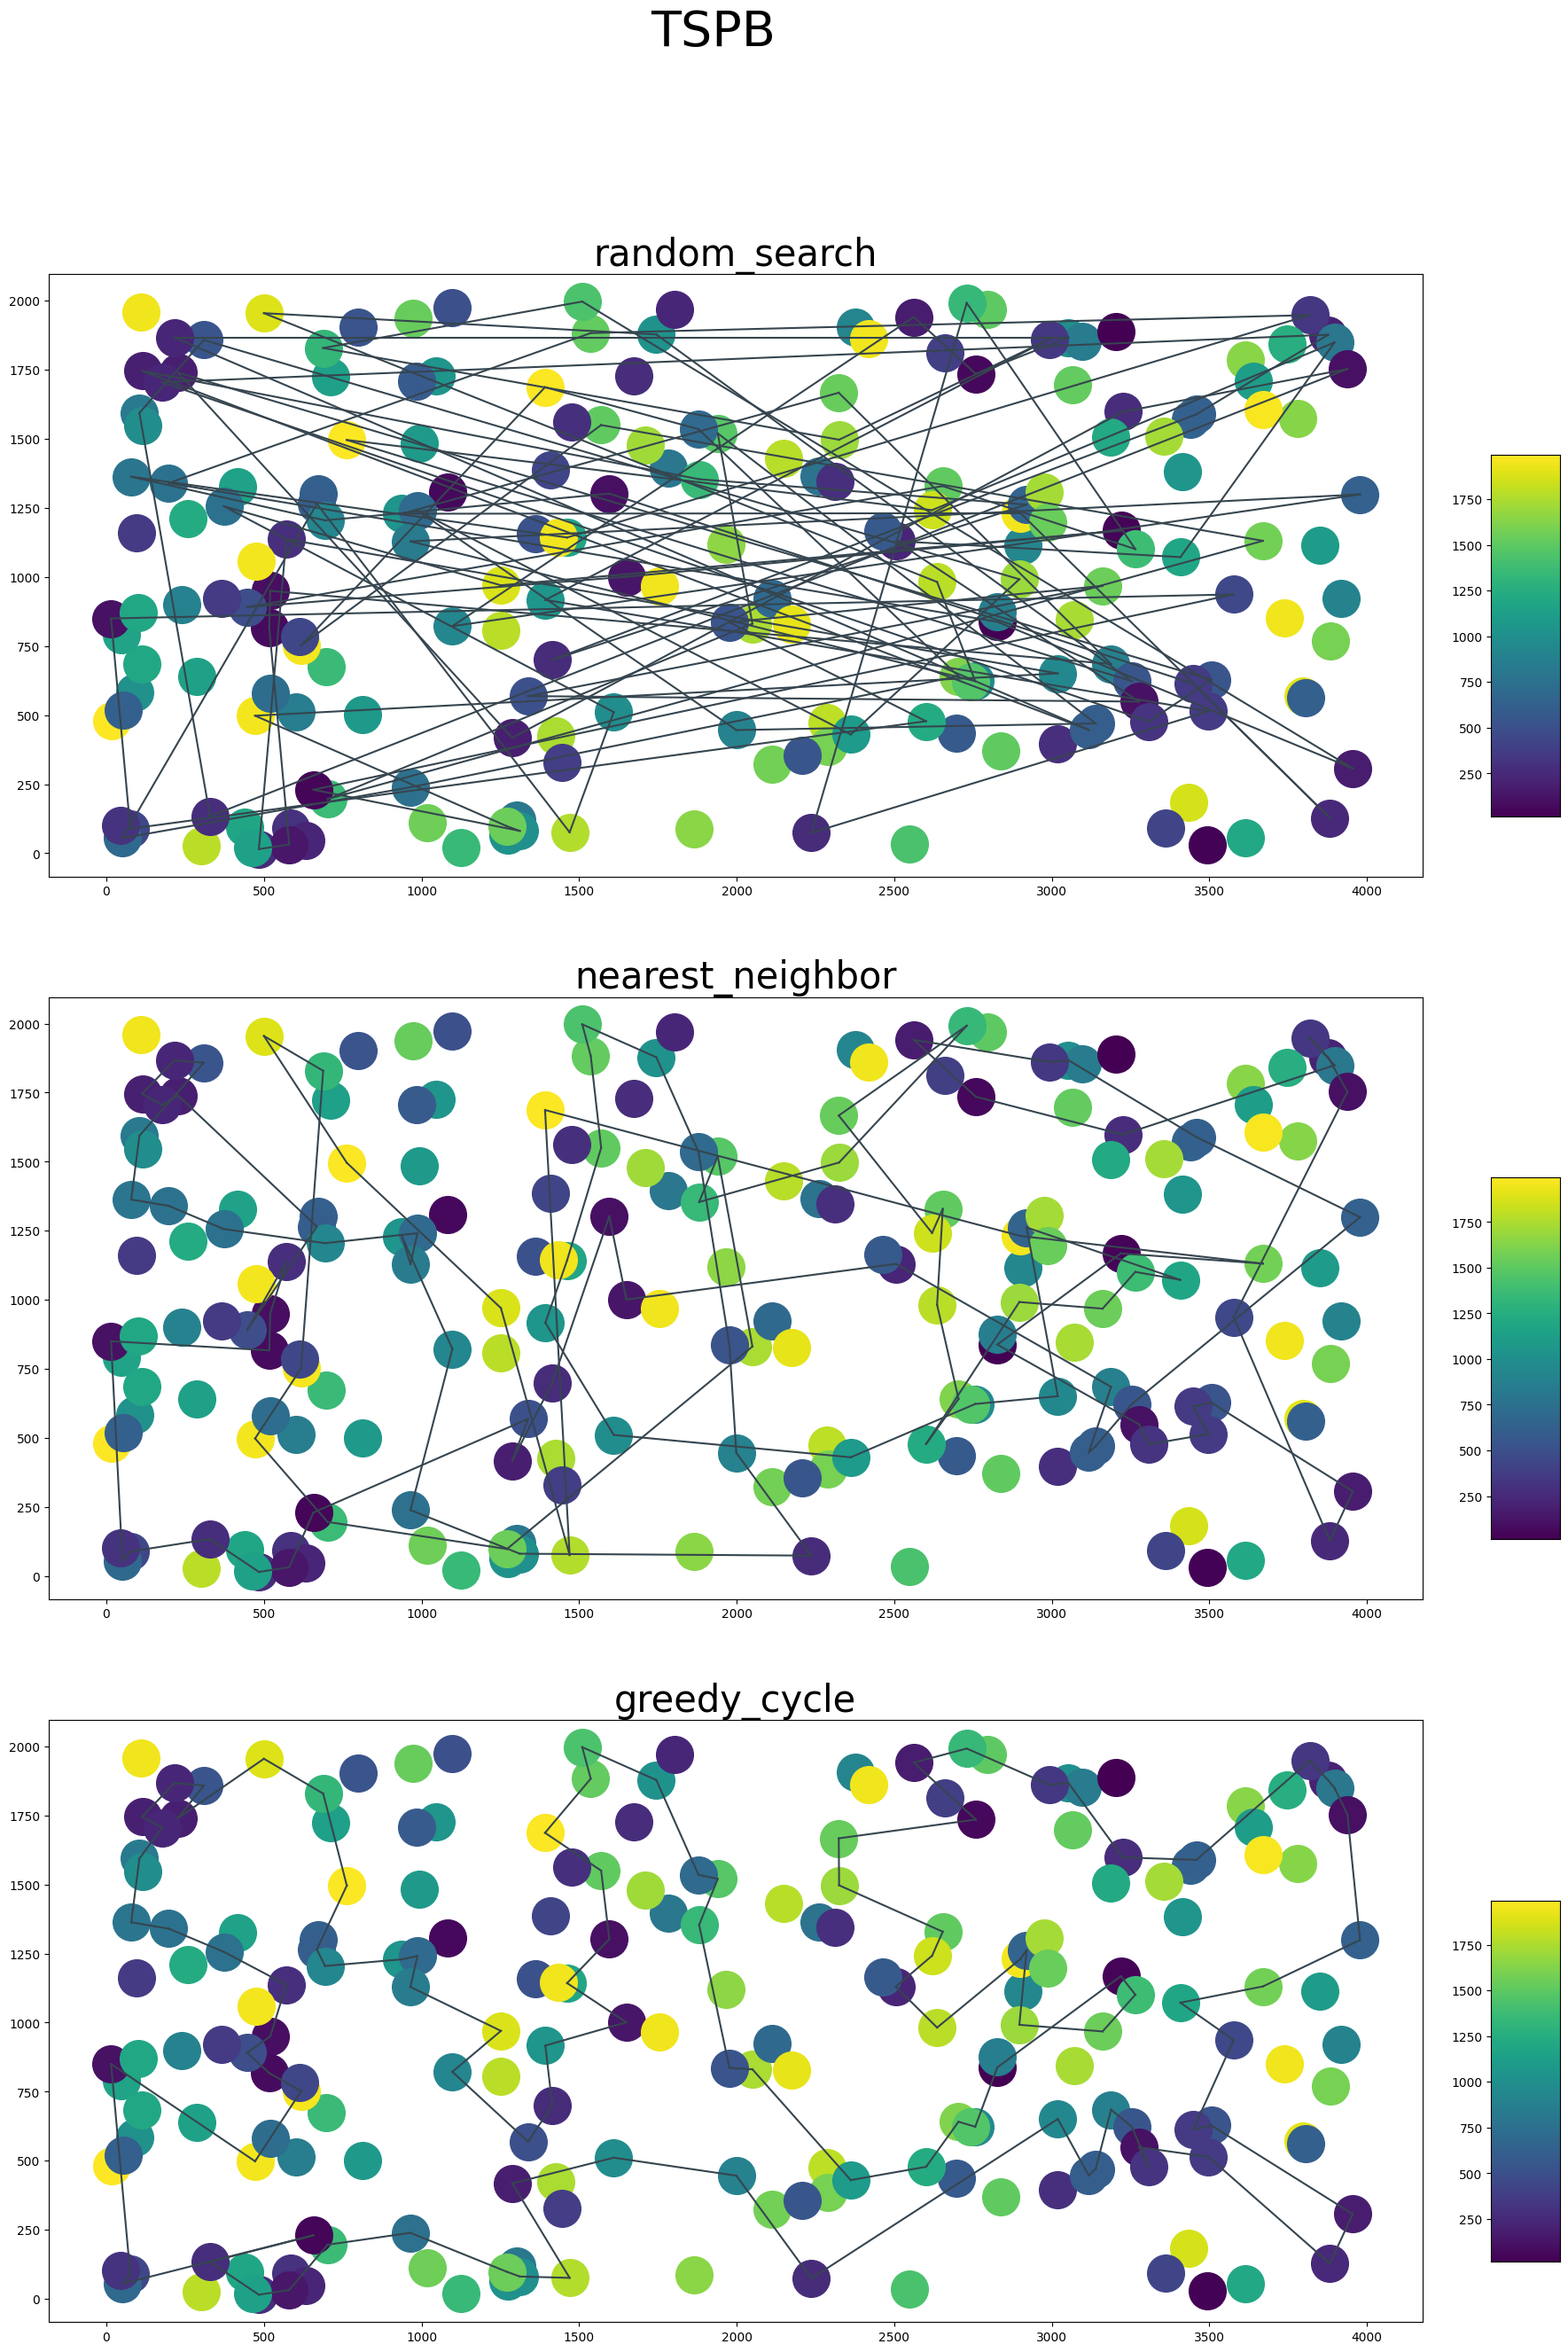

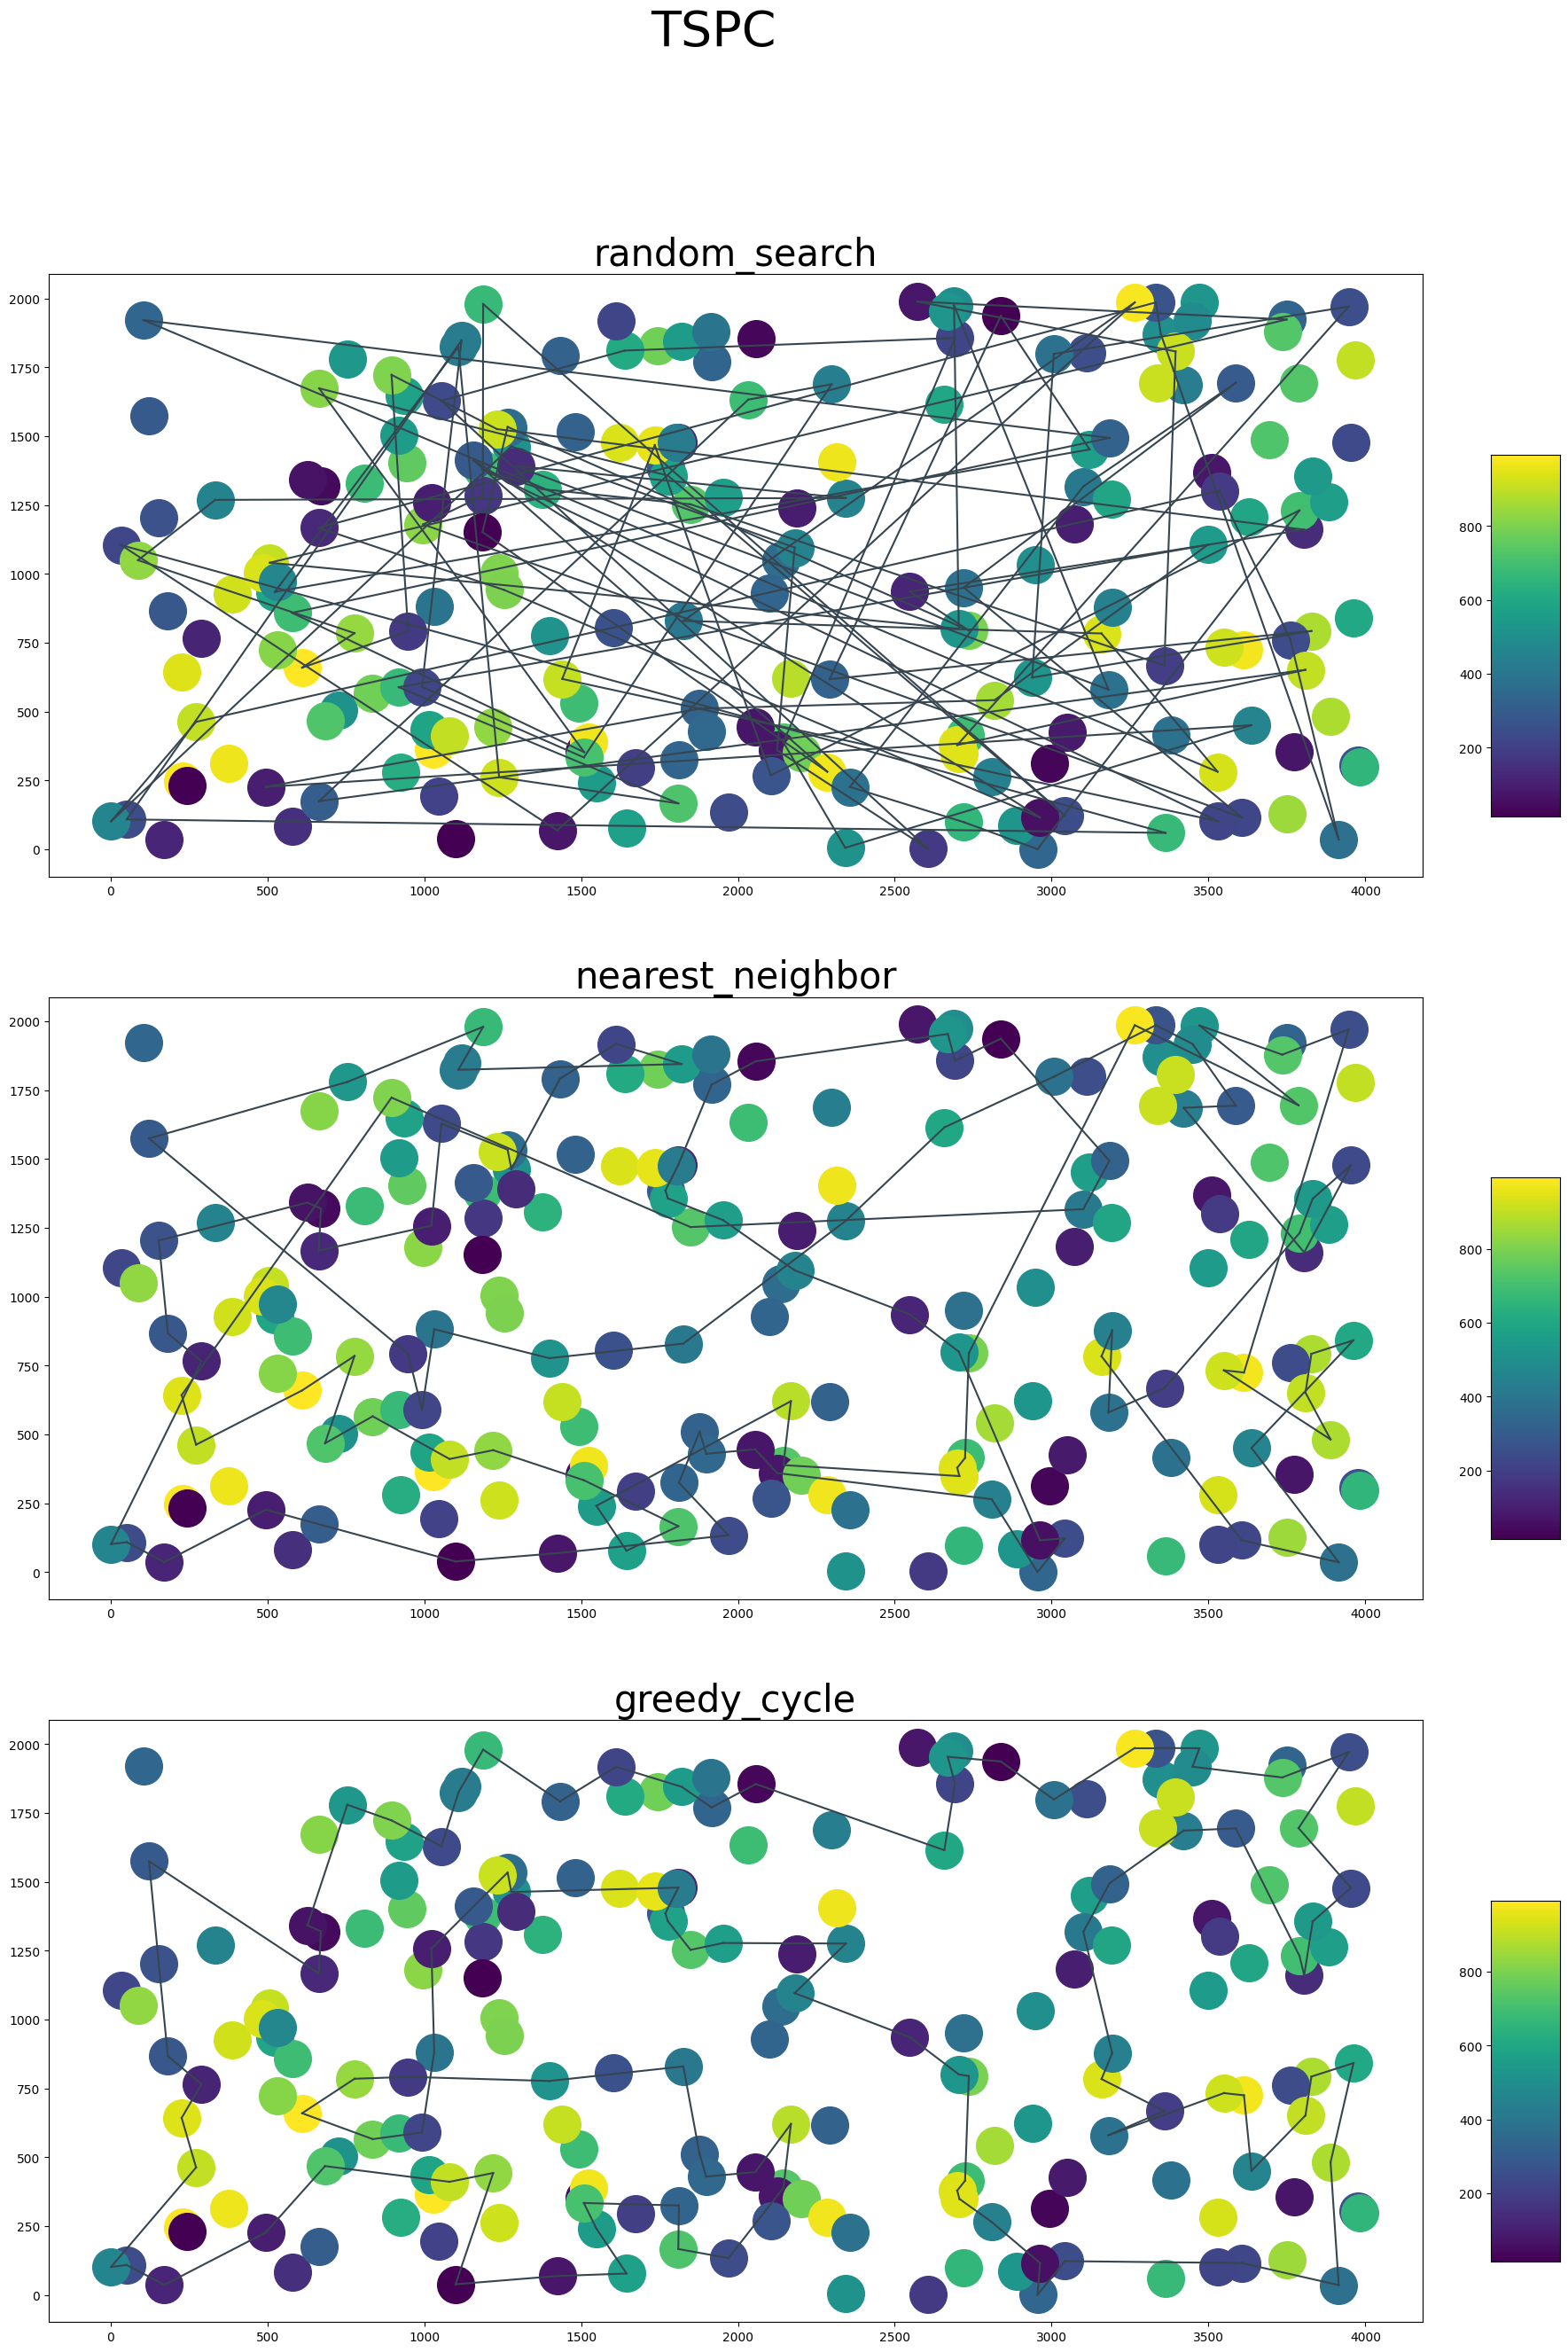

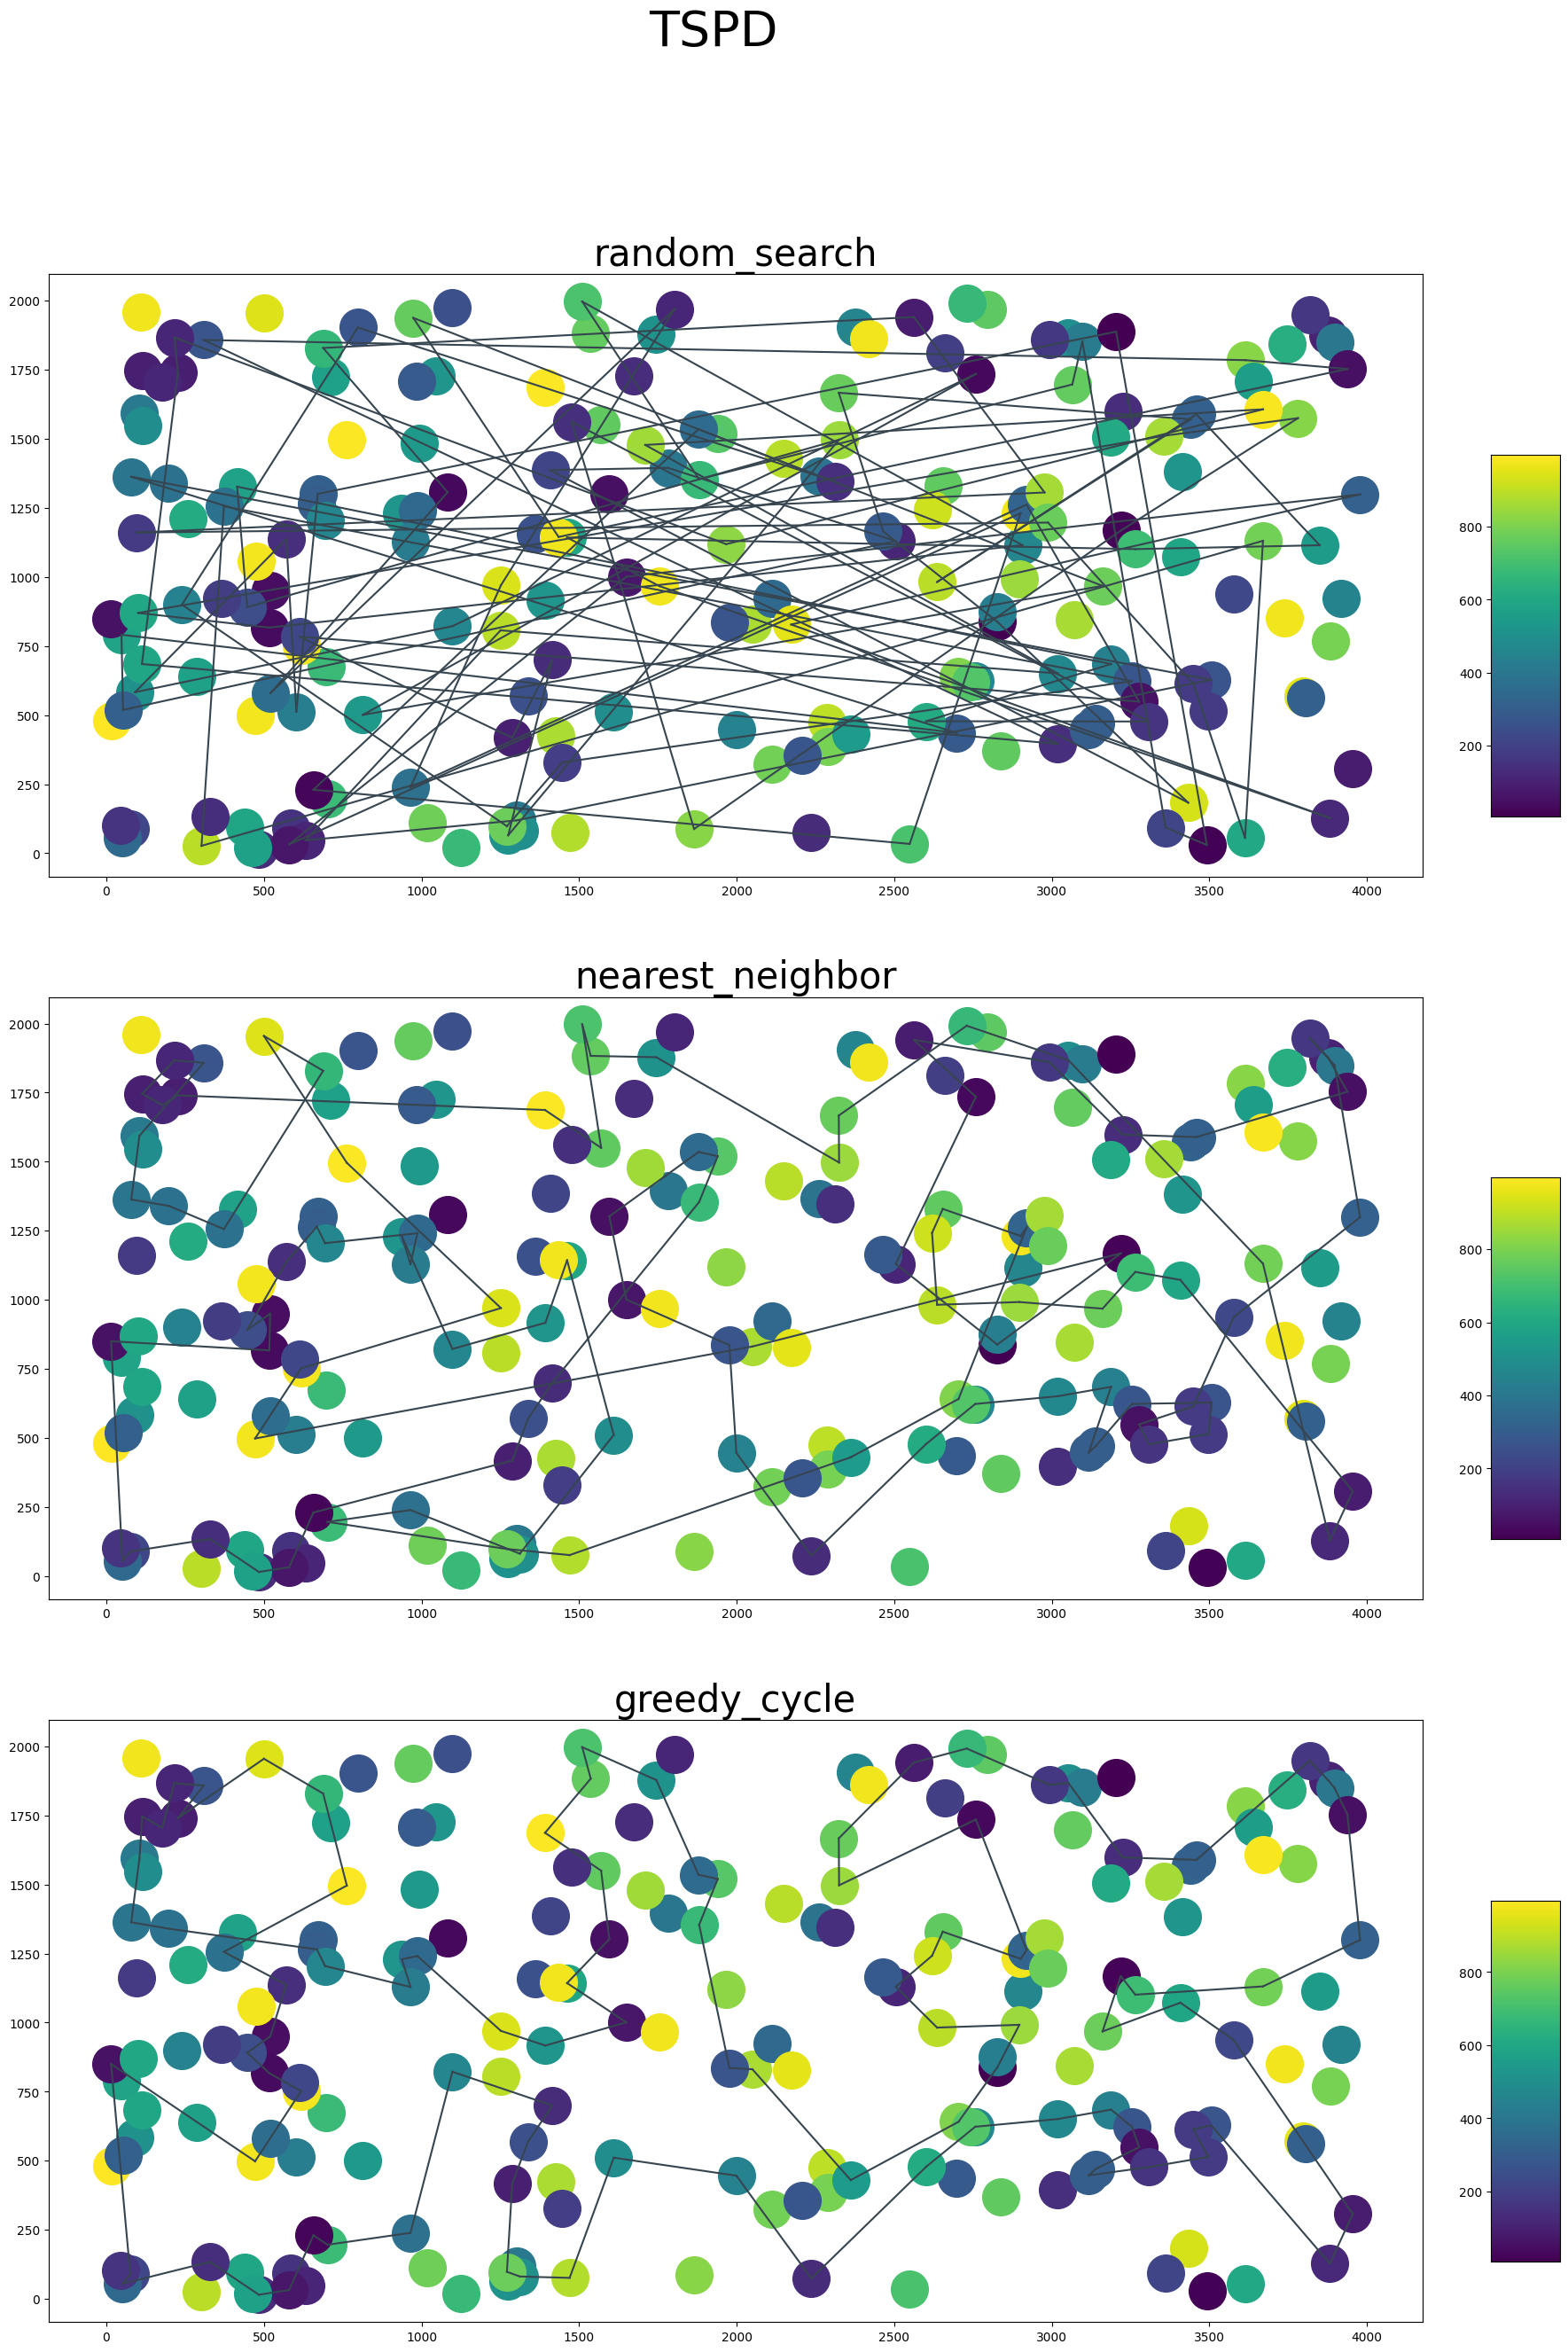

In [11]:
for instance, result in all_best_solutions.items():
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(instance, fontsize=40)

#     df = datas[instance]
    path = "../data"
    main_df = pd.read_csv(f"{path}/{instance}.csv", sep=';', header=None, names=['x', 'y', 'cost'])
    weights = main_df['cost']
    
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    
    
    for algo, solution in result.items():
        for i in range(len(main_df)):
            x, y, cost = main_df.iloc[i]['x'], main_df.iloc[i]['y'], main_df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=30, color=cmap(norm(cost)))
        df = datas[instance][algo]
        ax[idx].set_title(algo, fontsize=30)
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            
#             ax[idx].plot(x, y, "o", markersize=30, color=cmap(norm(cost)))
            ax[idx].plot((x, x_next), (y, y_next), "-", color='#36454f')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='#36454f')
#         ax[idx].plot(x_next, y_next, 'o', markersize=30, color=cmap(norm(cost)))
    
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        idx += 1
        
    plt.savefig(f'plots/{instance}.png', dpi=300)